<a href="https://colab.research.google.com/github/filipesartori/Inteligencia-Artificial/blob/main/Classifica%C3%A7%C3%A3o_de_sentimentos_com_Spacy_(TWITTER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de textos do Twitter com spaCy

## Importação e instalação das bibliotecas

In [12]:
!pip install -q spacy==2.2.3

In [13]:
import spacy
spacy.__version__

'2.2.3'

In [14]:
!python3 -m spacy download pt

     |████████████████████████████████| 21.2 MB 1.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [15]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np
import re

## Carregamento das bases de dados

In [79]:
base_treinamento = pd.read_csv('/content/Train50.csv', delimiter = ';')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


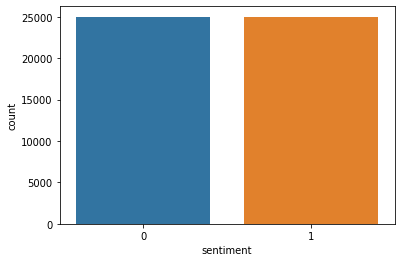

In [80]:
sns.countplot(base_treinamento['sentiment'], label = 'Contagem');

In [81]:
base_treinamento.drop(['id', 'tweet_date', 'query_used'], axis=1, inplace=True)

In [83]:
base_treinamento.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1


In [84]:
base_teste = pd.read_csv('/content/Test.csv', delimiter=';')

In [85]:
base_teste.drop(['id', 'tweet_date', 'query_used'], axis=1, inplace=True)

## Função para pré-processamento dos textos

- Letras minúsculas
- Nome do usuário (@)
- URLs
- Espaços em branco
- Emoticons
- Stop words
- Lematização
- Pontuações

In [86]:
pln = spacy.load('pt')

In [87]:
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

In [88]:
def preprocessamento(texto):
  texto = texto.lower()
  
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)

  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

  texto = re.sub(r" +", ' ', texto)

  lista_emocoes = {':)': 'emocaopositiva',
                   ':d': 'emocaopositiva',
                   ':(': 'emocaonegativa'}
  for emocao in lista_emocoes:
    texto = texto.replace(emocao, lista_emocoes[emocao]) 


  documento = pln(texto)                  

  lista = []
  for token in documento:
    lista.append(token.lemma_)

  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]  
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return lista  



## Limpeza dos textos

In [89]:
base_treinamento.head(10)

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1
5,@KingJokerLeto mas amiga eu to aqui ainda :),1
6,"@RivasJairo Bravo, Jairo!!! :)))",1
7,@inquilinasls @Spotify socorro ksoaksosks acho...,1
8,"@chimekarlla gosto muito de fazenda :) , mas m...",1
9,Amanha vou ver venom :D,1


In [90]:
base_treinamento['tweet_text'] = base_treinamento['tweet_text'].apply(preprocessamento)

In [91]:
base_treinamento.head()

,tweet_text,sentiment
0,o pessoa certo parir seriar o valer e azeved...,1
1,parir mim precisamente o contrário emocaopos...,1
2,video hoje ... pensar falar sobrar o meter csg...,1
3,aaaaaaaa amar polaroids expressar o quantum to...,1
4,valorizar o coração menino vc diferente o sorr...,1


In [92]:
base_teste['tweet_text'] = base_teste['tweet_text'].apply(preprocessamento)

In [93]:
base_teste.head()

,tweet_text,sentiment
0,obrigar emocaopositiva,1
1,pa puta parir emocaopositiva,1
2,querer desconto 14/08 ⭐ ⭐ ⭐ ⭐ ⭐ 🌐 conferir o l...,1
3,vcs ajudar galera pelar amor butera emocaoposi...,1
4,casar zé e o morrer sono chegar o casar e fica...,1


## Tratamento da classe

In [156]:
base_dados_treinamento_final = []
for texto, emocao in zip(base_treinamento['tweet_text'], base_treinamento['sentiment']):
  if emocao == 1:
    dic = ({'POSITIVO': True, 'NEGATIVO': False})
  elif emocao == 0:
    dic = ({'POSITIVO': False, 'NEGATIVO': True})

  base_dados_treinamento_final.append([texto, dic.copy()])    


In [ ]:
base_dados_treinamento_final

## Criação do classificador

In [159]:
modelo = spacy.blank('pt')
categorias = modelo.create_pipe("textcat")
categorias.add_label("POSITIVO")
categorias.add_label("NEGATIVO")
modelo.add_pipe(categorias)
historico = []

In [160]:
modelo.begin_training()
for epoca in range(5):
  random.shuffle(base_dados_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512):
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    modelo.update(textos, annotations, losses=losses)
    historico.append(losses)
  if epoca % 5 == 0:
    print(losses)

{'textcat': 7.870316117208898e-06}


In [161]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat')) 

In [162]:
historico_loss = np.array(historico_loss)
historico_loss

array([7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
       7.87031612e-06, 7.87031612e-06, 7.87031612e-06, 7.87031612e-06,
      

Text(0, 0.5, 'Erro')

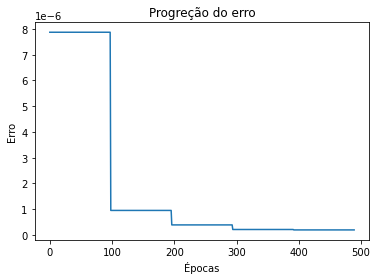

In [163]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progreção do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')

In [164]:
modelo.to_disk('modelo3')

## Testes com uma frase

In [165]:
modelo_carregado = spacy.load('modelo3')

In [166]:
texto_positivo = base_teste['tweet_text'][21]
texto_positivo

'  ficar feliz q recíproco emocaopositiva'

In [167]:
previsao = modelo_carregado(texto_positivo)

In [168]:
previsao.cats

{'NEGATIVO': 4.539786823443137e-05, 'POSITIVO': 0.9998680353164673}

In [169]:
texto_positivo = 'eu gosto muito de vc'
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'gostar vc'

In [170]:
modelo_carregado(texto_positivo).cats

{'NEGATIVO': 0.08078965544700623, 'POSITIVO': 0.9702866077423096}

In [171]:
base_teste['tweet_text'][4000]


'tô triste filmar mulan o mushu emocaonegativa'

In [172]:
texto_negativo = base_teste['tweet_text'][4000]
previsao = modelo_carregado(texto_negativo)
previsao.cats

{'NEGATIVO': 0.9997504353523254, 'POSITIVO': 0.0009970574174076319}

## Avaliação na base de treinamento

In [174]:
previsoes = []
for texto in base_teste['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [ ]:
previsoes

In [176]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)        


In [177]:
respostas_reais = base_teste['sentiment'].values

In [178]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(respostas_reais, previsoes_final)

0.9972

In [180]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[2495,    5],
       [   9, 2491]])

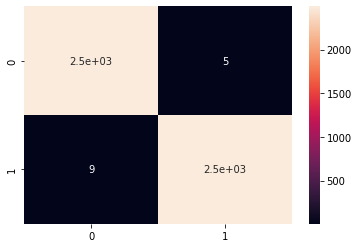

In [181]:
sns.heatmap(cm, annot=True)

## Teste de textos

In [210]:
teste_texto = input('Escreva uma frase:')
preprocessamento(teste_texto)
texto_pessoa = teste_texto
previsao = modelo_carregado(texto_pessoa)
previsao2 = previsao.cats
previsao2


Escreva uma frase:hoje vou na academia


{'NEGATIVO': 0.9898221492767334, 'POSITIVO': 0.06294535845518112}